In [1]:
import glob
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import scvi
import torch
from scib_metrics.benchmark import Benchmarker
import matplotlib.pyplot as plt

/hdd/wenjiayue/Envs/miniconda/scvi-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#**Load Data**

In [ ]:
adata_list = []

##**smart-seq**

In [ ]:
SS_file_path = glob.glob("/data/wenjiayue/Data/smart-seq/*/*.h5ad")
len(SS_file_path)

In [ ]:
for file in SS_file_path:
    adata = sc.read_h5ad(file)
    adata.obs['platform'] = "SS" 
    adata_list.append(adata)

##**10x**

In [ ]:
tenX_file_path = glob.glob("/data/wenjiayue/Data/10x_20240515_XY/*/*.h5ad")
len(tenX_file_path)

In [ ]:
for file in tenX_file_path:
    adata = sc.read_h5ad(file)
    #更改index
    adata.obs['combined_index'] = adata.obs['sample_id'].astype(str) + '_' + adata.obs.index.astype(str) 
    adata.obs.set_index('combined_index', inplace=True)
    #增加platform信息
    adata.obs['platform'] = "tenX" 
    adata_list.append(adata)

In [ ]:
len(adata_list)

In [ ]:
concatenated_adata = anndata.concat(adata_list, index_unique=None, join='outer')

In [ ]:
concatenated_adata

In [10]:
concatenated_adata.write_h5ad("/hdd/wenjiayue/scRNA_Lung/scVI_intergration/SS1_Tenx6_concat_adata.h5ad")

#**Dataset preprocessing**

In [2]:
concatenated_adata = sc.read_h5ad("/hdd/wenjiayue/scRNA_Lung/scVI_intergration/SS1_Tenx6_concat_adata.h5ad")

In [3]:
concatenated_adata.layers["counts"] = concatenated_adata.X.copy()
sc.pp.normalize_total(concatenated_adata, target_sum=1e4)
sc.pp.log1p(concatenated_adata)

In [4]:
concatenated_adata.raw = concatenated_adata  # keep full dimension safe

In [5]:
sc.pp.highly_variable_genes(
    concatenated_adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="sample_id",
    subset=True,
    span=0.5
)

/hdd/wenjiayue/Envs/miniconda/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


#**Integration with scVI**

In [6]:
scvi.model.SCVI.setup_anndata(concatenated_adata, layer="counts", batch_key="sample_id")
model = scvi.model.SCVI(concatenated_adata, n_layers=len(concatenated_adata.layers), n_latent=30, gene_likelihood="nb")

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated CUDA installation found.
Version JAX was built against: 11080
Minimum supported: 12010
Installed version: 11080
The local installation version must be no lower than 12010.
--------------------------------------------------
Outdated cuDNN installation found.
Version JAX was built against: 8907
Minimum supported: 8900
Installed version: 8700
The local installation version must be no lower than 8900.
--------------------------------------------------
Outdated cuBLAS installation found.
Version JAX was built against: 111103
Minimum supported: 120100
Installed version: 111103
The local installation version must be no lower than 120100.
--------------------------------------------------
Outdated cuSPARSE installation found.
Version JAX was built against: 11705
Minimum supported: 12100
Installed version: 11705
The local installation version must be no lower than 12100. (Set TF_

In [7]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/hdd/wenjiayue/Envs/miniconda/scvi-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Epoch 64/64: 100%|██████████| 64/64 [12:03<00:00, 11.37s/it, v_num=1, train_loss_step=560, train_loss_epoch=567]

`Trainer.fit` stopped: `max_epochs=64` reached.


Epoch 64/64: 100%|██████████| 64/64 [12:03<00:00, 11.31s/it, v_num=1, train_loss_step=560, train_loss_epoch=567]


In [8]:
#evaluate the latent representation of each cell and add it to the AnnData object
SCVI_LATENT_KEY = "X_scVI"
concatenated_adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [9]:
sc.pp.neighbors(concatenated_adata, use_rep=SCVI_LATENT_KEY)
#Leiden算法将细胞划分为不同cluster
sc.tl.leiden(concatenated_adata)

/tmp/ipykernel_185845/2381104696.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(concatenated_adata)


In [10]:
#pymde-an alternative to UMAP that is GPU-accelerated
SCVI_MDE_KEY = "X_scVI_MDE"
concatenated_adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(concatenated_adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


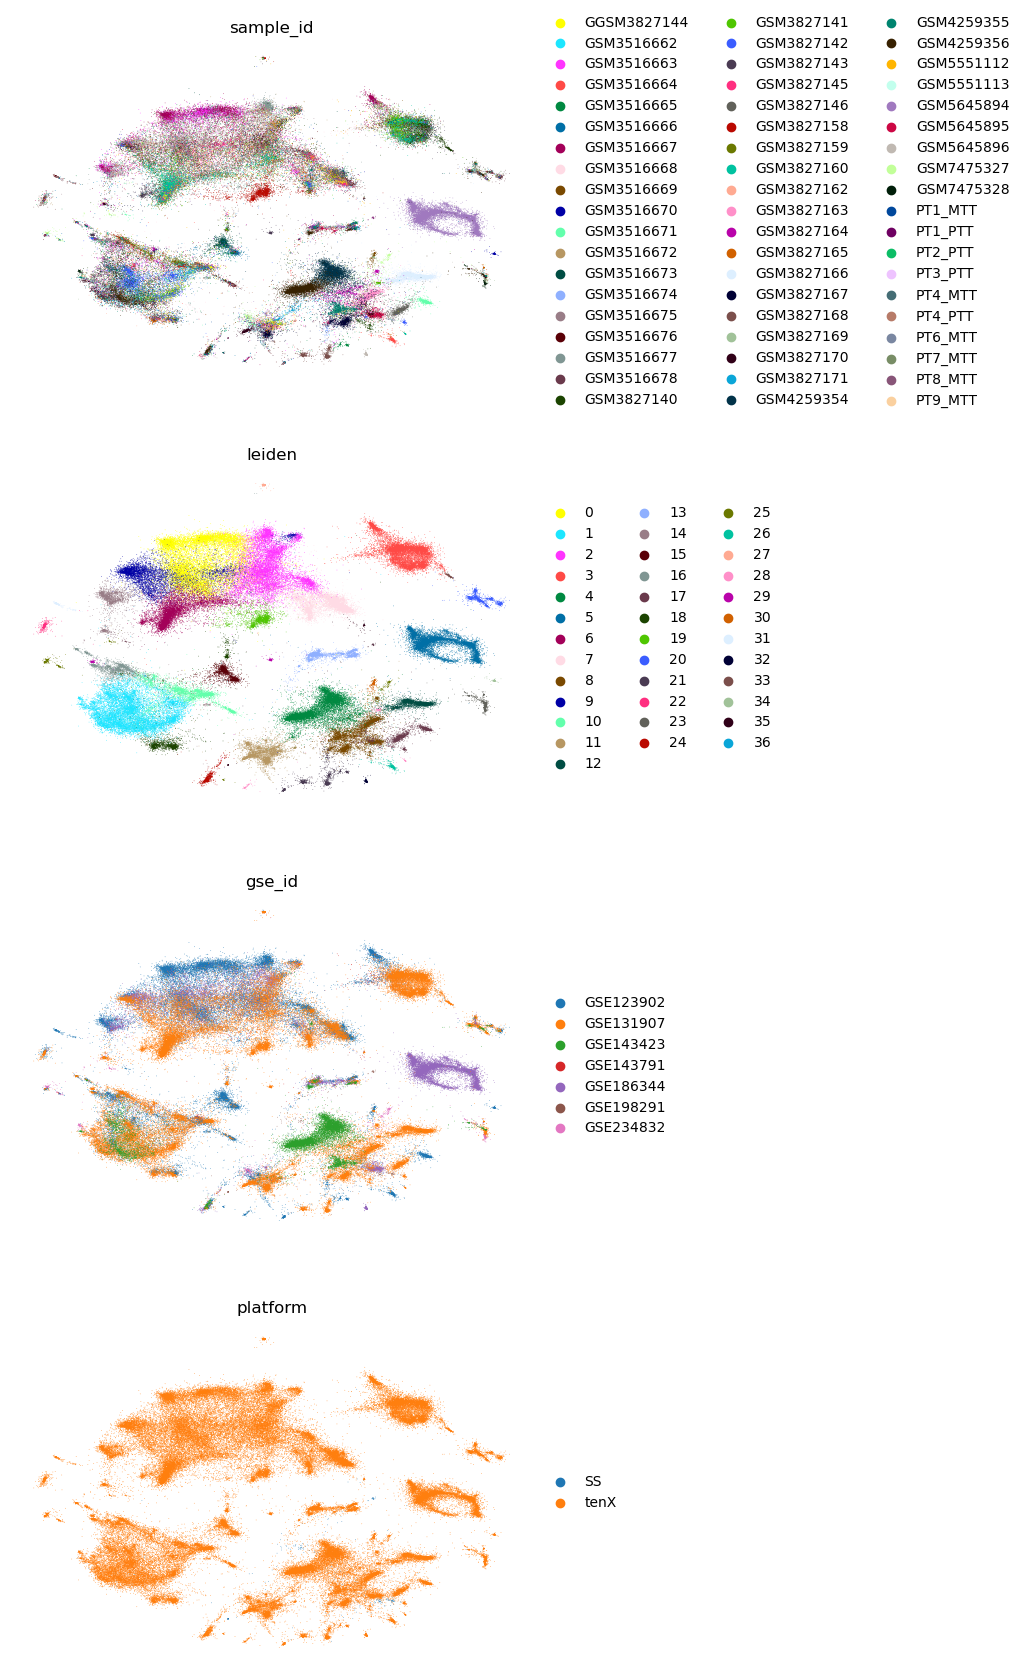

In [11]:
sc.pl.embedding(
    concatenated_adata,
    basis=SCVI_MDE_KEY,
    color=["sample_id","leiden","gse_id","platform"],
    frameon=False,
    ncols=1
)

In [12]:
concatenated_adata.obs['platform'].value_counts()

platform
tenX    123768
SS         423
Name: count, dtype: int64

In [13]:
concatenated_adata.write_h5ad("/hdd/wenjiayue/scRNA_Lung/scVI_intergration/After_scVI_adata.h5ad")

In [14]:
#model save and load
model.save("/hdd/wenjiayue/scRNA_Lung/scVI_intergration/my_model/")
model = scvi.model.SCVI.load("/hdd/wenjiayue/scRNA_Lung/scVI_intergration/my_model/", concatenated_adata, use_cuda=True)

In [27]:
concatenated_adata.obs['Cell_type'].value_counts()

Cell_type
Unknown             68871
T lymphocytes       15970
Epithelial cells    13635
Myeloid cells       12401
B lymphocytes        8986
NK cells             2362
Oligodendrocytes      662
Fibroblasts           596
MAST cells            493
Undetermined          215
Name: count, dtype: int64

In [14]:
concatenated_adata.obs['Cell_type'] = concatenated_adata.obs['Cell_type'].astype(str)

In [15]:
concatenated_adata.obs['Cell_type'] = concatenated_adata.obs['Cell_type'].replace('nan', pd.NA)
concatenated_adata.obs['Cell_type'] = concatenated_adata.obs['Cell_type'].fillna('Unknown')

In [16]:
nan_count = concatenated_adata.obs['Cell_type'].isna().sum()
nan_count

0

In [17]:
concatenated_adata.obs

,sample_id,gse_id,n_genes,percent_mito,scrublet_score,predicted_doublet,platform,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,Samples,Cell_type,Cell_type.refined,Cell_subtype,samples,_scvi_batch,_scvi_labels,leiden
PT4_PTT65,PT4_PTT,GSE198291,6416,0.0,0.090909,False,SS,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,52,0,1
PT4_PTT66,PT4_PTT,GSE198291,9288,0.0,0.068966,False,SS,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,52,0,8
PT4_PTT67,PT4_PTT,GSE198291,7401,0.0,0.052632,False,SS,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,52,0,1
PT4_PTT68,PT4_PTT,GSE198291,7923,0.0,0.121951,False,SS,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,52,0,4
PT4_PTT69,PT4_PTT,GSE198291,6314,0.0,0.121951,False,SS,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,52,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM4259356_lbm3_TTTGTCAGTGATGCCC,GSM4259356,GSE143423,2237,NaN,0.083333,False,tenX,2237.0,5322.0,223.0,4.190154,NaN,Unknown,NaN,NaN,lbm3,39,0,4
GSM4259356_lbm3_TTTGTCAGTGGCCCTA,GSM4259356,GSE143423,2447,NaN,0.257732,False,tenX,2447.0,7384.0,279.0,3.778440,NaN,Unknown,NaN,NaN,lbm3,39,0,4
GSM4259356_lbm3_TTTGTCAGTTACGCGC,GSM4259356,GSE143423,588,NaN,0.039044,False,tenX,588.0,2712.0,59.0,2.175516,NaN,Unknown,NaN,NaN,lbm3,39,0,20
GSM4259356_lbm3_TTTGTCATCGGTGTCG,GSM4259356,GSE143423,2522,NaN,0.047702,False,tenX,2522.0,7335.0,360.0,4.907975,NaN,Unknown,NaN,NaN,lbm3,39,0,4


In [28]:
pd.crosstab(concatenated_adata.obs['gse_id'],concatenated_adata.obs['Cell_type'])

Cell_type,B lymphocytes,Epithelial cells,Fibroblasts,MAST cells,Myeloid cells,NK cells,Oligodendrocytes,T lymphocytes,Undetermined,Unknown
gse_id,,,,,,,,,,
GSE123902,0,0,0,0,0,0,0,0,0,35669
GSE131907,8986,13635,596,493,12401,2362,662,15970,215,0
GSE143423,0,0,0,0,0,0,0,0,0,11322
GSE143791,0,0,0,0,0,0,0,0,0,1590
GSE186344,0,0,0,0,0,0,0,0,0,18243
GSE198291,0,0,0,0,0,0,0,0,0,423
GSE234832,0,0,0,0,0,0,0,0,0,1624


#**scANVI**

In [18]:
#在SCVI训练好的模型和cell_type进行进一步训练
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,                    # SCVI 模型
    adata=concatenated_adata,              # 包含标签信息的 AnnData 对象
    labels_key="Cell_type",    # 标签信息所在的键
    unlabeled_category="Unknown" # 未标记样本的类别标签
)

In [19]:
scanvi_model.train()

INFO     Training for 10 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/hdd/wenjiayue/Envs/miniconda/scvi-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Epoch 10/10: 100%|██████████| 10/10 [04:24<00:00, 25.68s/it, v_num=1, train_loss_step=587, train_loss_epoch=550]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [04:24<00:00, 26.41s/it, v_num=1, train_loss_step=587, train_loss_epoch=550]


In [20]:
SCANVI_LATENT_KEY = "X_scANVI"
concatenated_adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(concatenated_adata)

In [29]:
#predict the missing cell types
SCANVI_PREDICTION_KEY = "C_scANVI"
concatenated_adata.obs[SCANVI_PREDICTION_KEY] = scanvi_model.predict(concatenated_adata)

In [31]:
concatenated_adata.obs['C_scANVI'].value_counts()

C_scANVI
T lymphocytes       39979
Epithelial cells    37120
Myeloid cells       22879
B lymphocytes       12252
NK cells             5558
Fibroblasts          3848
Oligodendrocytes     1159
MAST cells           1138
Undetermined          258
Name: count, dtype: int64

In [21]:
SCANVI_MDE_KEY = "X_scANVI_MDE"
concatenated_adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(concatenated_adata.obsm[SCANVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


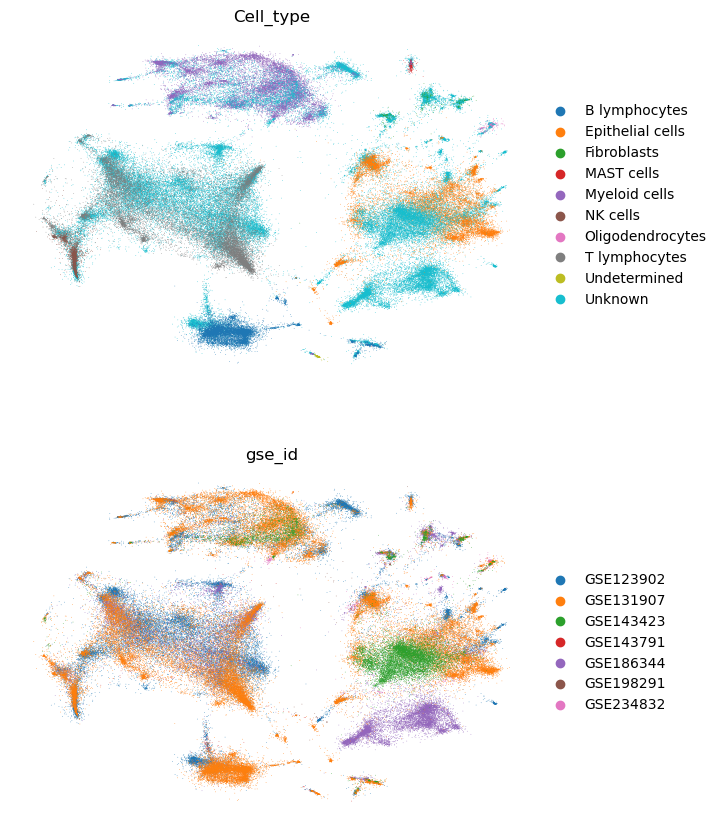

In [22]:
sc.pl.embedding(
    concatenated_adata, basis=SCANVI_MDE_KEY, color=["Cell_type", "gse_id"], ncols=1, frameon=False
)

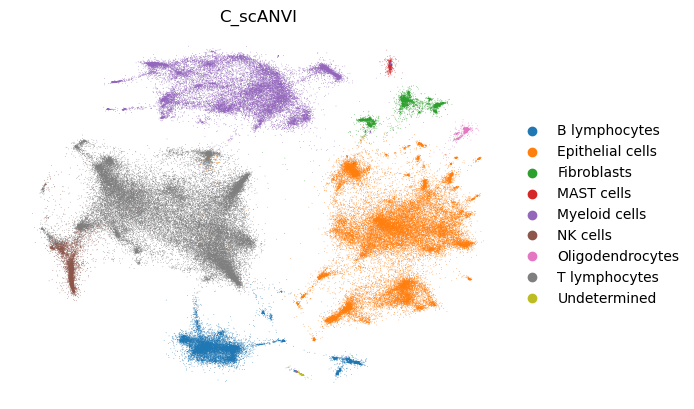

In [32]:
sc.pl.embedding(
    concatenated_adata, basis=SCANVI_MDE_KEY, color='C_scANVI', ncols=1, frameon=False
)

In [ ]:
selected_obs_indices = concatenated_adata.obs['gse_id'] == selected_gse_id
filtered_adata = concatenated_adata[selected_obs_indices, :].copy()


#**Benchmark**

In [23]:
concatenated_adata

AnnData object with n_obs × n_vars = 124191 × 2000
    obs: 'sample_id', 'gse_id', 'n_genes', 'percent_mito', 'scrublet_score', 'predicted_doublet', 'platform', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Samples', 'Cell_type', 'Cell_type.refined', 'Cell_subtype', 'samples', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'leiden', 'sample_id_colors', 'leiden_colors', 'gse_id_colors', 'platform_colors', 'Cell_type_colors'
    obsm: 'X_scVI', 'X_scVI_MDE', 'X_scANVI', 'X_scANVI_MDE'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [24]:
bm = Benchmarker(
    concatenated_adata,
    batch_key="sample_id",
    label_key="Cell_type",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
    #n_jobs=-1
)
bm.benchmark()

/hdd/wenjiayue/Envs/miniconda/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Metrics:  60%|██████    | 6/10 [35:12<14:44, 221.20s/it, Batch correction: kbet_per_label]/hdd/wenjiayue/Envs/miniconda/scvi-env/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/hdd/wenjiayue/Envs/miniconda/scvi-env/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/hdd/wenjiayue/Envs/mini

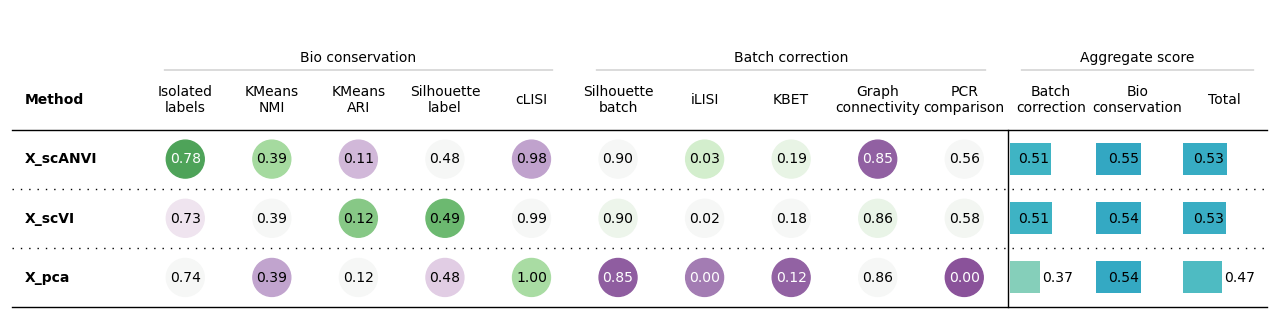

In [25]:
bm.plot_results_table(min_max_scale=False)

In [26]:
bm.get_results(min_max_scale=False)


,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_pca,0.736298,0.389781,0.116972,0.479938,1.0,0.849035,0.003331,0.118255,0.862036,0.0,0.366532,0.544598,0.473371
X_scVI,0.729378,0.391475,0.123251,0.485061,0.990626,0.903239,0.01924,0.176754,0.863129,0.581549,0.508782,0.543958,0.529888
X_scANVI,0.777659,0.393164,0.112832,0.481454,0.980788,0.8981,0.025754,0.185854,0.854255,0.56124,0.505041,0.549179,0.531524
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score
